# Gathering and graphing frequencies from Korp

Let's say I'm interested in frequencies of particular words in some material stored in the [Finnish Language Bank](https://kitwiki.csc.fi/twiki/bin/view/FinCLARIN/KielipankkiKoti). They have this [Korp web interface](https://korp.csc.fi/), but that doesn't cut it for my purposes. 

Luckily, they also have a programmatic [API](https://kitwiki.csc.fi/twiki/bin/view/FinCLARIN/KielipankkiHelpKorpWebService) (Application Program Interface), which I should be able to use to gather the data for my own purposes. 

By reading the documentation (and maybe some googling), I learn that the API uses the [HTTP protocol](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol), and return results as [JSON](https://en.wikipedia.org/wiki/JSON). Now, I just need to find out how to use those in my chosen programming environment of Python. So, I query google for [HTTP JSON in Python](https://www.google.fi/search?q=HTTP+JSON+in+python), which gives me some actual code to copypaste, as well as further links if I need to know more.

Now, all I need to do is to be able to format the query according to the requirements of the Korp API.

In [2]:
# In Korp, corpus is a variable containing the corpora we are querying, as identified in Korp. 
# I got this list from selecting corpora in the interface and copy pasting from the address line
corpus = "ethesis_en_phd_mm,ethesis_en_phd_hum,ethesis_en_phd_bio,ethesis_en_phd_beh,ethesis_en_phd_ot,ethesis_en_phd_med,ethesis_en_phd_far,ethesis_en_phd_math,ethesis_en_phd_valt,ethesis_en_phd_teo,ethesis_en_phd_el,ethesis_en_ma_mm,ethesis_en_ma_ai,ethesis_en_ma_hum,ethesis_en_ma_bio,ethesis_en_ma_beh,ethesis_en_ma_far,ethesis_en_ma_ot,ethesis_en_ma_med,ethesis_en_ma_sci,ethesis_en_ma_valt,ethesis_en_ma_teo,ethesis_en_ma_el,ethesis_en_dissabs,ethesis_en_maabs,mulcold_en,elfa"
# However, for some reason, the API requires these to be in UPPER CASE, so let's just do that.
corpus = corpus.upper()

# query is the word (actually a regular expression) we're interested in.
# TASK 1: alter the regular expression to search for both everything beginning with vaivai as well as waiwai 
# (also test whatever else you like)
# if you really cannot figure it out, see http://pastebin.com/TPTHJe9j for the answer.
query = 'national.*'

# number of hits to return from Korp (+1)
end = '150000'

print("Query set to " + query)

Query set to national.*


For regular expressions, which are immensely useful also in all kinds of text processing tasks, see [this](http://www.regular-expressions.info/reference.html) and if you further want to modify the query, see [the CPQ query language tutorial](http://cwb.sourceforge.net/files/CQP_Tutorial/node8.html).

Now, the next bit, copypasted and modified from the results of the Google search, calls the API of Korp and returns results to us as a JSON object. It can take a long while, so be patient (For this reason, the default timeout for the call has been increased to two minutes).

In [3]:
import requests

response = requests.get("https://korp.csc.fi/cgi-bin/korp.cgi?cqp=%5Bword%20%3D%20%22"+query+"%22%5D%20%5B%5D&sort=keyword&command=query&indent=2&defaultcontext=0+words&show=lemma&start=0&end="+end+"&show_struct=text_dateto,text_datefrom&corpus="+corpus,timeout=120)
json_data = response.json()
print("Hit count "+str(json_data['hits'])+" should be below our end ("+str(end)+") if we are to get all data.")
print("Actually got "+str(len(json_data['kwic']))+" hits.")
json_data

Hit count 34660 should be below our end (150000) if we are to get all data.
Actually got 34660 hits.


{'corpus_hits': {'ELFA': 580,
  'ETHESIS_EN_DISSABS': 339,
  'ETHESIS_EN_MAABS': 232,
  'ETHESIS_EN_MA_AI': 211,
  'ETHESIS_EN_MA_BEH': 131,
  'ETHESIS_EN_MA_BIO': 32,
  'ETHESIS_EN_MA_EL': 0,
  'ETHESIS_EN_MA_FAR': 132,
  'ETHESIS_EN_MA_HUM': 841,
  'ETHESIS_EN_MA_MED': 18,
  'ETHESIS_EN_MA_MM': 883,
  'ETHESIS_EN_MA_OT': 1586,
  'ETHESIS_EN_MA_SCI': 674,
  'ETHESIS_EN_MA_TEO': 132,
  'ETHESIS_EN_MA_VALT': 7058,
  'ETHESIS_EN_PHD_BEH': 1169,
  'ETHESIS_EN_PHD_BIO': 605,
  'ETHESIS_EN_PHD_EL': 254,
  'ETHESIS_EN_PHD_FAR': 236,
  'ETHESIS_EN_PHD_HUM': 2739,
  'ETHESIS_EN_PHD_MATH': 1018,
  'ETHESIS_EN_PHD_MED': 2951,
  'ETHESIS_EN_PHD_MM': 1334,
  'ETHESIS_EN_PHD_OT': 2494,
  'ETHESIS_EN_PHD_TEO': 308,
  'ETHESIS_EN_PHD_VALT': 8316,
  'MULCOLD_EN': 387},
 'corpus_order': ['ETHESIS_EN_PHD_MM',
  'ETHESIS_EN_PHD_HUM',
  'ETHESIS_EN_PHD_BIO',
  'ETHESIS_EN_PHD_BEH',
  'ETHESIS_EN_PHD_OT',
  'ETHESIS_EN_PHD_MED',
  'ETHESIS_EN_PHD_FAR',
  'ETHESIS_EN_PHD_MATH',
  'ETHESIS_EN_PHD_VALT',
  'E

The above gives us the data as individual occurrences, but what we really want is a way to map each lemma to the count of its occurrences by year. The following code does this by assembling a nested Python [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries). You'd do well to learn these basic flow control and data structures of the language of your choice, because they are then the glue that allows you to hook together the libraries that do the actual work.

In [5]:
sw = set(['and','or'])
import re

lemmaYearCountDict = dict()
for match in json_data['kwic']:
    if match['structs']['text_datefrom'] != None and match['structs']['text_datefrom'] != '':
        year = match['structs']['text_datefrom'][:4]
        lemma = match['tokens'][1]['word']
        if re.match('^\w+$',lemma) and not lemma in sw:
            if not lemma in lemmaYearCountDict:
                lemmaYearCountDict[lemma]=dict()
            if not year in lemmaYearCountDict[lemma]:
                lemmaYearCountDict[lemma][year]=1
            else:
                lemmaYearCountDict[lemma][year]+=1
    else:
        print("BAD ENTRY:",match)
lemmaYearCountDict


BAD ENTRY: {'corpus': 'ETHESIS_EN_PHD_MED', 'match': {'end': 2, 'position': 31681514, 'start': 0}, 'structs': {'text_datefrom': None, 'text_dateto': None}, 'tokens': [{'word': 'national'}, {'word': 'Health'}]}
BAD ENTRY: {'corpus': 'ETHESIS_EN_PHD_MED', 'match': {'end': 2, 'position': 33136535, 'start': 0}, 'structs': {'text_datefrom': None, 'text_dateto': None}, 'tokens': [{'word': 'national'}, {'word': 'product'}]}
BAD ENTRY: {'corpus': 'ETHESIS_EN_PHD_MED', 'match': {'end': 2, 'position': 33138347, 'start': 0}, 'structs': {'text_datefrom': None, 'text_dateto': None}, 'tokens': [{'word': 'national'}, {'word': 'product'}]}
BAD ENTRY: {'corpus': 'ETHESIS_EN_MA_HUM', 'match': {'end': 2, 'position': 2311660, 'start': 0}, 'structs': {'text_datefrom': '', 'text_dateto': ''}, 'tokens': [{'word': 'national'}, {'word': ','}]}
BAD ENTRY: {'corpus': 'ETHESIS_EN_MA_HUM', 'match': {'end': 2, 'position': 2318680, 'start': 0}, 'structs': {'text_datefrom': '', 'text_dateto': ''}, 'tokens': [{'word':

{'abatement': {'2013': 3},
 'accounting': {'2009': 1,
  '2005': 1,
  '2014': 3,
  '2016': 3,
  '2008': 7,
  '2011': 1},
 'accounts': {'2001': 1,
  '2011': 4,
  '2008': 4,
  '2014': 9,
  '2016': 23,
  '2005': 3,
  '2013': 1,
  '2003': 1,
  '2009': 4,
  '2010': 4,
  '2004': 1,
  '2012': 1},
 'action': {'2011': 4,
  '2012': 3,
  '2015': 1,
  '2013': 5,
  '2007': 1,
  '2000': 1,
  '2004': 1,
  '2016': 1,
  '2009': 2,
  '2014': 5},
 'actions': {'2011': 1, '2006': 3, '2007': 1},
 'actors': {'2009': 2,
  '2007': 1,
  '2008': 8,
  '2014': 4,
  '2010': 2,
  '2015': 4,
  '2005': 8,
  '2006': 2,
  '2011': 3,
  '2016': 2,
  '2012': 3},
 'adaptation': {'2011': 2, '2001': 2, '2005': 6, '2009': 1},
 'administrations': {'2011': 2, '2000': 2, '2005': 2, '2014': 1, '2016': 1},
 'AEPs': {'2007': 1},
 'afforestation': {'2007': 1, '2016': 1},
 'agencies': {'2006': 1,
  '2008': 3,
  '2004': 1,
  '2016': 1,
  '2007': 1,
  '2013': 1,
  '2014': 2,
  '2003': 1},
 'aggregate': {'2001': 1},
 'aggregation': {'2013

Now, using dictionaries, I have the data in the structure I want. Time to move into processing it further and eventually visualizing it. 

Googling [Python data analysis](https://www.google.fi/search?q=python+data+analysis), I'm directed to [Pandas](http://pandas.pydata.org/), a well known and highly regarded library for doing just that. Reading its documentation however, I come to understand that I have to immediately transform my nice simple dict into its [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe). Luckily, some additional googling and documentation reading again gives me also the actual code I need.

In [12]:
import pandas as pd
import numpy as np

# TASK 2: the code to turn a dict to a frame is really really simple, but what is it? Fix the next line.
# you really shouldn't get stuck here, but if you do, there's http://pastebin.com/dmfpxdgg
lemmaFrame = pd.DataFrame(lemmaYearCountDict)
lemmaFrame.index.names = ['Word']
# By default empty values in a dataframe are left as NaNs (Not a Number), but that gave me problems in later calculations. So, after some further documentation reading I added the .replace(np.nan,0) transformation
# the .T at the end transposes the data frame so that the resulting table has words as rows and dates as columns instead of the other way round
lemmaFrame = lemmaFrame.replace(np.nan,0).T
print('Frame dimensions: '+str(lemmaFrame.columns.size)+"x"+str(lemmaFrame.index.size))
lemmaFrame.head()


Now, we can start plotting!

For example, we can plot instances of all matched words by year

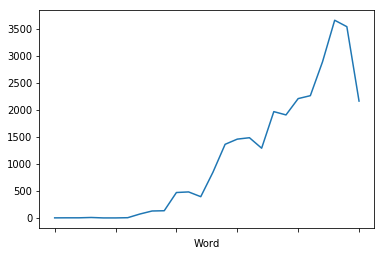

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

lemmaFrame.sum().plot()

But, what I really wanted to do is graph frequencies for individual words. This however is problematic, as as you may already know, the KLK data in Korp has horrible OCR problems (Looking at the data frame dimensions, there are tens of thousands of different word forms, which is certainly far too much). To counter those, let's write the data out to a CSV file and load it in another tool ([OpenRefine](http://openrefine.org/)) for some interactive cleanup.

In [13]:
lemmaFrame.to_csv("waiwa.csv")
print("Wrote waiwa.csv")

Wrote waiwa.csv


Now view and download [waiwa.csv](waiwa.csv), and move on to processing it using [OpenRefine](/refine/). Follow the [separate tutorial](https://docs.google.com/document/d/1m6EEbPCSnjg6F1VPBj4sa8NNnMWPGduXqirGwXirDxI/edit?usp=sharing) on what to do there.

After processing, we need to reload the data from the one exported by OpenRefine. [Upload it](../tree) as waiwa2.csv in order to run the following code (you'll have to wait a bit for the file to upload depending on the speed of your network connection. The UI unfortunately doesn't give any indication of this).

In [14]:
lemmaFrame2 = pd.read_csv('waiwa2.csv')
print('Frame dimensions: '+str(lemmaFrame2.columns.size)+"x"+str(lemmaFrame2.index.size))
lemmaFrame2.head()

Frame dimensions: 27x4217


Hmm, the frame is still the same length as before. That is because while OpenRefine unified naming conventions, it did not actually join any rows. Let's do that next.

In [15]:
lemmaFrame3 = lemmaFrame2.groupby('Unnamed: 0').aggregate(np.sum)
print('Frame dimensions: '+str(lemmaFrame3.columns.size)+"x"+str(lemmaFrame3.index.size)+" (vs "+str(lemmaFrame2.columns.size)+"x"+str(lemmaFrame2.index.size)+")")

Frame dimensions: 26x4216 (vs 27x4217)


Now that's more like it. Finally, to get individual word level graphs, lets limit the words to those occurring most in the total corpus. 

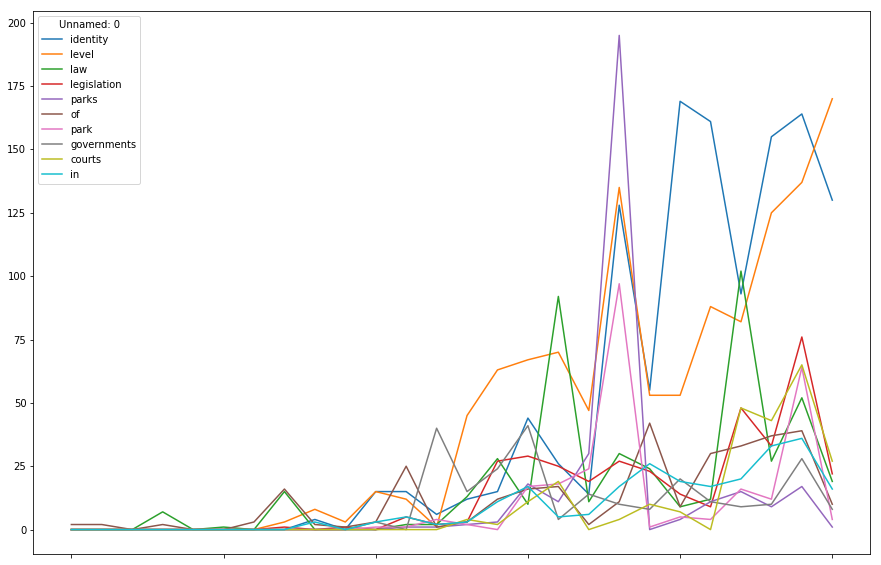

In [16]:
from IPython.display import display
sorted =lemmaFrame3.T.sum()
sorted.sort_values(inplace=True,ascending=False)
top10 = lemmaFrame3.T[sorted.index[:10]]
display(top10.T)
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
top10.plot()